<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumArmsClassifier_01_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_annotations= pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [5]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [6]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [7]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [8]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Train and evaluate the number of arms extractor

In [9]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [10]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [16]:
model.fit(df_train.text, df_train.num_arms_clean)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['taient', 'tais', 'tait', 'tant', 'tante', 'tantes', 'tants', 'tiez', 'tions'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [17]:
pred_num_arms = model.predict(df_val.text)

In [18]:
pred_num_arms_proba = model.predict_proba(df_val.text)

In [19]:
num_arms_ground_truths = df_val.num_arms_clean

In [20]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.5246212121212122


''

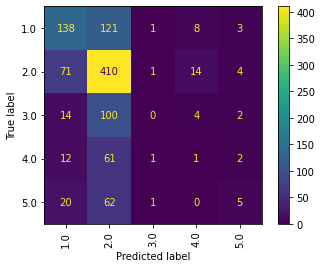

In [21]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;

In [24]:
num_arms_ground_truths

12       2.0
49       1.0
50       2.0
51       5.0
52       1.0
        ... 
11902    2.0
11903    3.0
11904    1.0
11906    1.0
11907    5.0
Name: num_arms_clean, Length: 1056, dtype: float64

In [25]:
pred_num_arms_proba

array([[0.10632971, 0.49892996, 0.16962436, 0.12009205, 0.10502392],
       [0.44022132, 0.30524532, 0.09164134, 0.05112639, 0.11176562],
       [0.10300025, 0.66848999, 0.12972532, 0.06102005, 0.03776438],
       ...,
       [0.11345047, 0.54973601, 0.17504953, 0.09658469, 0.0651793 ],
       [0.68733429, 0.23638716, 0.04521031, 0.01671465, 0.01435358],
       [0.20605104, 0.43600072, 0.15450458, 0.09015196, 0.11329171]])

In [35]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for i in range(1,5+1):
  roc_auc = roc_auc_score(num_arms_ground_truths == i, pred_num_arms_proba[:, i - 1])
  print (f"Num arms ROC AUC {roc_auc} for {i} arm(s)")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

Num arms ROC AUC 0.790295437986227 for 1 arm(s)
Num arms ROC AUC 0.6900539568345323 for 2 arm(s)
Num arms ROC AUC 0.625329415954416 for 3 arm(s)
Num arms ROC AUC 0.6448735125956782 for 4 arm(s)
Num arms ROC AUC 0.8174657212622088 for 5 arm(s)
Average 0.7136036089266125


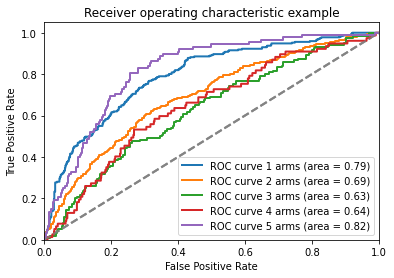

In [33]:
plt.figure()
lw = 2
    
for i in range(1,6):
    fpr, tpr, _ = roc_curve(num_arms_ground_truths == i, pred_num_arms_proba[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {i} arms (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [34]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")

Streaming output truncated to the last 5000 lines.
1006	tissue
1007	activity
1008	occurring
1009	termination
1010	indication
1011	receipt
1012	noted
1013	gastrointestinal
1014	ltd
1015	containing
1016	bj
1017	capsules
1018	otherwise
1019	table
1020	must
1021	avoid
1022	calcium
1023	er
1024	enrolled
1025	mg
1026	assurance
1027	allowed
1028	meets
1029	soon
1030	evaluated
1031	authorities
1032	class
1033	document
1034	best
1035	anti
1036	cci
1037	minimum
1038	br
1039	previously
1040	volume
1041	ongoing
1042	ss
1043	jul
1044	white
1045	men
1046	half
1047	specified
1048	ph
1049	dated
1050	female
1051	ca
1052	cfr
1053	opinion
1054	maintenance
1055	expression
1056	experienced
1057	resolution
1058	accountability
1059	initiated
1060	fully
1061	abnormal
1062	serum
1063	agent
1064	supply
1065	january
1066	september
1067	responsibility
1068	standards
1069	signing
1070	fatigue
1071	sep
1072	weekly
1073	sd
1074	percent
1075	clear
1076	exam
1077	sciences
1078	changed
1079	cm
1080	organ
1081	periphera